## Directory settings

In [1]:
# ======================================================
# Directory settings
# ======================================================
import os
import pandas as pd

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
TRAIN_PATH = '../input/ranzcr-clip-catheter-line-classification/train'

## Data Loading

In [2]:
train = pd.read_csv('../input/oof-df-data/train_folds.csv')
test = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/sample_submission.csv')
train_annotations = pd.read_csv('../input/ranzcr-clip-catheter-line-classification/train_annotations.csv')

# delete suspicious data
train = train[train['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)
train_annotations = train_annotations[train_annotations['StudyInstanceUID'] != '1.2.826.0.1.3680043.8.498.93345761486297843389996628528592497280'].reset_index(drop=True)

## CFG

In [3]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug=False
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    print_freq=100
    num_workers=4
    model_name='resnet200d_320'
    student='../input/startingpointschestx/resnet200d_320_chestx.pth'
    teacher='../input/005-training-resnext-step1-data/resnet200d_320_fold0_best_loss.pth'
    weights=[0.5, 1]
    size=640
    scheduler='CosineAnnealingLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=5
    #factor=0.2 # ReduceLROnPlateau
    #patience=4 # ReduceLROnPlateau
    #eps=1e-6 # ReduceLROnPlateau
    T_max=5 # CosineAnnealingLR
    #T_0=5 # CosineAnnealingWarmRestarts
    lr=1e-5 # 1e-4
    min_lr=1e-6
    batch_size=8 # 64
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=416
    target_size=11
    target_cols=['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold=5
    trn_fold=[0] # [0, 1, 2, 3, 4]
    train=True
    
if CFG.debug:
    CFG.epochs = 3
    train = train.sample(n=3000, random_state=CFG.seed).reset_index(drop=True)

In [4]:
if CFG.device == 'TPU':
    import os
    os.system('curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py')
    os.system('python pytorch-xla-env-setup.py --version 1.7 --apt-packages libomp5 libopenblas-dev')
    os.system('export XLA_USE_BF16=1')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    CFG.lr = CFG.lr * CFG.nprocs
    CFG.batch_size = CFG.batch_size // CFG.nprocs

## Library

In [5]:
# ====================================================
# Library
# ====================================================
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import ast
import copy
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.utils import check_random_state
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

if CFG.device == 'TPU':
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

## Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

## CV splits

In [7]:
folds = train.copy()
# Fold = GroupKFold(n_splits=CFG.n_fold)
# groups = folds['PatientID'].values
# for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
#     folds.loc[val_index, 'fold'] = int(n)
# folds['fold'] = folds['fold'].astype(int)
display(folds.groupby('fold').size())

fold
0    6002
1    6041
2    5991
3    6018
4    6030
dtype: int64

## Dataset

In [8]:
# ====================================================
# Dataset
# ====================================================
COLOR_MAP = {'ETT - Abnormal': (255, 0, 0),
             'ETT - Borderline': (0, 255, 0),
             'ETT - Normal': (0, 0, 255),
             'NGT - Abnormal': (255, 255, 0),
             'NGT - Borderline': (255, 0, 255),
             'NGT - Incompletely Imaged': (0, 255, 255),
             'NGT - Normal': (128, 0, 0),
             'CVC - Abnormal': (0, 128, 0),
             'CVC - Borderline': (0, 0, 128),
             'CVC - Normal': (128, 128, 0),
             'Swan Ganz Catheter Present': (128, 0, 128),
            }

class TrainDataset(Dataset):
    def __init__(self, df, df_annotations, use_annot=False, annot_size=50, transform=None):
        self.df = df
        self.df_annotations = df_annotations
        self.use_annot = use_annot
        self.annot_size = annot_size
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
        labels = torch.tensor(self.labels[idx]).float()
        if self.use_annot:
            image_annot = image.copy()
            query_string = f"StudyInstanceUID == '{file_name}'"
            df = self.df_annotations.query(query_string)
            for i, row in df.iterrows():
                label = row["label"]
                data = np.array(ast.literal_eval(row["data"]))
                for d in data:
                    image_annot[d[1]-self.annot_size//2:d[1]+self.annot_size//2,
                                d[0]-self.annot_size//2:d[0]+self.annot_size//2,
                                :] = COLOR_MAP[label]
            if self.transform:
                augmented = self.transform(image=image, image_annot=image_annot)
                image = augmented['image']
                image_annot = augmented['image_annot']
            return image, image_annot, labels
        
        else:
            if self.transform:
                augmented = self.transform(image=image)
                image = augmented['image']
            return image, labels

## Transforms

In [9]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):
    
    if data == 'train':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ], additional_targets={'image_annot': 'image'})
    
    elif data == 'check':
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
            HueSaturationValue(p=0.2, hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2),
            ShiftScaleRotate(p=0.2, shift_limit=0.0625, scale_limit=0.2, rotate_limit=20),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            #Normalize(
            #    mean=[0.485, 0.456, 0.406],
            #    std=[0.229, 0.224, 0.225],
            #),
            ToTensorV2(),
        ], additional_targets={'image_annot': 'image'})
    
    elif data == 'valid':
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

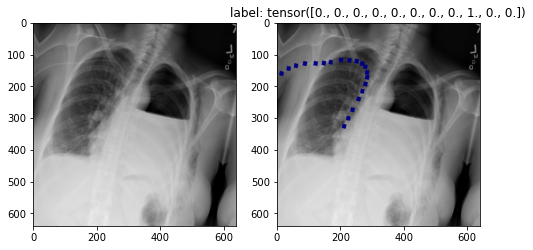

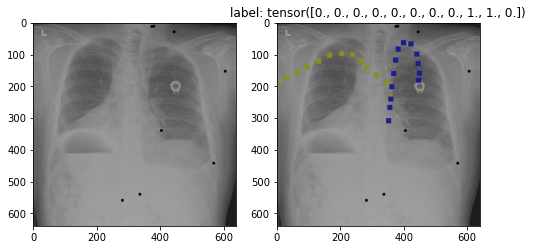

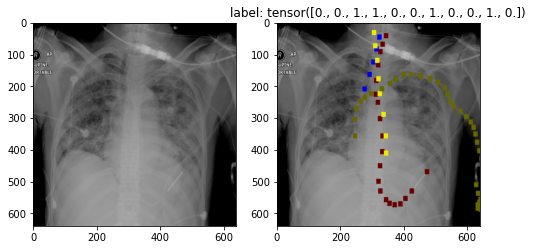

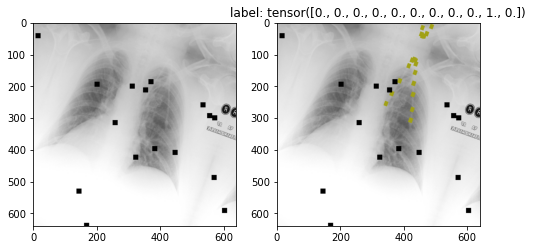

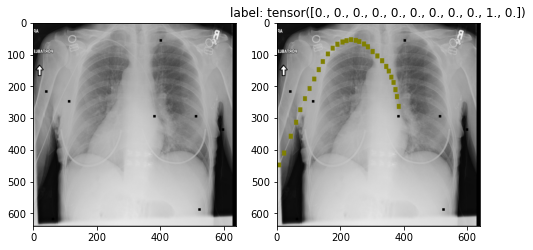

In [10]:
from matplotlib import pyplot as plt

train_dataset = TrainDataset(folds[folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True), 
                             train_annotations, use_annot=True, transform=get_transforms(data='check'))

for i in range(5):
    image, image_annot, label = train_dataset[i]
    fig, axes = plt.subplots(1, 2, figsize=(8, 8))
    axes[0].imshow(image.transpose(0, 1).transpose(1, 2))  # どのタイミングでshapeが(C, H, W)になっていたのかがわからない。
    axes[1].imshow(image_annot.transpose(0, 1).transpose(1, 2))
    plt.title(f'label: {label}')
    plt.show()

## MODEL

In [11]:
class PAM_Module(nn.Module):
    """ Position attention module"""
    #Ref from SAGAN
    def __init__(self, in_dim):
        super(PAM_Module, self).__init__()
        self.chanel_in = in_dim

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X (HxW) X (HxW)
        """
        m_batchsize, C, height, width = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width*height).permute(0, 2, 1)
        proj_key = self.key_conv(x).view(m_batchsize, -1, width*height)
        energy = torch.bmm(proj_query, proj_key)
        attention = torch.softmax(energy, dim=-1)
        proj_value = self.value_conv(x).view(m_batchsize, -1, width*height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


class CAM_Module(nn.Module):
    """ Channel attention module"""
    def __init__(self, in_dim):
        super(CAM_Module, self).__init__()
        self.chanel_in = in_dim
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X H X W)
            returns :
                out : attention value + input feature
                attention: B X C X C
        """
        m_batchsize, C, height, width = x.size()
        proj_query = x.view(m_batchsize, C, -1)
        proj_key = x.view(m_batchsize, C, -1).permute(0, 2, 1)
        energy = torch.bmm(proj_query, proj_key)
        energy_new = torch.max(energy, -1, keepdim=True)[0].expand_as(energy)-energy
        attention = torch.softmax(energy_new, dim=-1)
        proj_value = x.view(m_batchsize, C, -1)

        out = torch.bmm(attention, proj_value)
        out = out.view(m_batchsize, C, height, width)

        out = self.gamma*out + x
        return out


class CBAM(nn.Module):
    def __init__(self, in_channels):
        # def __init__(self):
        super(CBAM, self).__init__()
        inter_channels = in_channels // 4
        self.conv1_c = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU(inplace=True))
        
        self.conv1_s = nn.Sequential(nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(inter_channels),
                                     nn.ReLU(inplace=True))

        self.channel_gate = CAM_Module(inter_channels)
        self.spatial_gate = PAM_Module(inter_channels)

        self.conv2_c = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU(inplace=True))
        self.conv2_a = nn.Sequential(nn.Conv2d(inter_channels, in_channels, 3, padding=1, bias=False),
                                     nn.BatchNorm2d(in_channels),
                                     nn.ReLU(inplace=True))

    def forward(self, x):
        feat1 = self.conv1_c(x)
        chnl_att = self.channel_gate(feat1)
        chnl_att = self.conv2_c(chnl_att)

        feat2 = self.conv1_s(x)
        spat_att = self.spatial_gate(feat2)
        spat_att = self.conv2_a(spat_att)

        x_out = chnl_att + spat_att

        return x_out

In [12]:
# ====================================================
# MODEL
# ====================================================
class CustomResNet200D(nn.Module):
    def __init__(self, model_name='resnet200d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features  = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        if pretrained:
            pretrained_path = '../input/startingpointschestx/resnet200d_320_chestx.pth'
#             self.model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu'))['model'])
            
            checkpoint = torch.load(pretrained_path, map_location='cpu')['model']
            for key in list(checkpoint.keys()):
                if 'model.' in key:
                    checkpoint[key.replace('model.', '')] = checkpoint[key]
                    del checkpoint[key]
            self.model.load_state_dict(checkpoint) 
            
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(n_features, CFG.target_size)
        
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        pooled_features = self.pooling(features).view(bs, -1)
        output = self.fc(pooled_features)
        return features, pooled_features, output
        
    

class CustomResNet200D_WLF(nn.Module):
    def __init__(self, model_name='resnet200d_320', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=False)
        n_features  = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)
        if pretrained:
            pretrained_path = '../input/startingpointschestx/resnet200d_320_chestx.pth'
#             self.model.load_state_dict(torch.load(pretrained_path, map_location=torch.device('cpu'))['model'])
            
            checkpoint = torch.load(pretrained_path, map_location='cpu')['model']
            for key in list(checkpoint.keys()):
                if 'model.' in key:
                    checkpoint[key.replace('model.', '')] = checkpoint[key]
                    del checkpoint[key]
            self.model.load_state_dict(checkpoint) 
            
            print(f'load {model_name} pretrained model')
        n_features = self.model.fc.in_features
        self.model.global_pool = nn.Identity()
        self.model.fc = nn.Identity()
        self.pooling = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Linear(n_features, CFG.target_size)
        
        self.local_fe = CBAM(n_features)
        self.classifier = nn.Sequential(nn.Linear(n_features + n_features, n_features), 
                                        nn.BatchNorm1d(n_features),
                                        nn.ReLU(inplace=True),
                                        nn.Linear(n_features, CFG.target_size))
        
    def forward(self, x):
        bs = x.size(0)
        features = self.model(x)
        
        global_features = self.pooling(features).view(bs, -1)
        
        local_features = self.local_fe(features)
        local_features = torch.sum(local_features, dim=[2, 3])  # ここ、どうしてsum？GAPではない？
        
        all_features = torch.cat([global_features, local_features], dim=1)
        output = self.classifier(all_features)
        
        return features, all_features, output

In [13]:
class CustomLoss(nn.Module):
    def __init__(self, weights=[1, 1]):
        super(CustomLoss, self).__init__()
        self.weights = weights
        
    def forward(self, teacher_features, features, y_pred, labels):
        consistency_loss = nn.MSELoss()(teacher_features.view(-1), features.view(-1))
        cls_loss = nn.BCEWithLogitsLoss()(y_pred, labels)
        loss = self.weights[0] * consistency_loss + self.weights[1] * cls_loss
        return loss

## Helper functions

In [14]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, teacher_model, model, criterion, optimizer, epoch, scheduler, device):
    if CFG.device == 'GPU':
        scaler = GradScaler()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, images_annot, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        with torch.no_grad():
            teacher_features, _, _ = teacher_model(images_annot.to(device))
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        if CFG.device == 'GPU':
            with autocast():
                features, _, y_preds = model(images)
                loss = criterion(teacher_features, features, y_preds, labels)
                # record loss
                losses.update(loss.item(), batch_size)
                if CFG.gradient_accumulation_steps > 1:
                    loss = loss / CFG.gradient_accumulation_steps
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
                if (step + 1) % CFG.gradient_accumulation_steps == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                    global_step += 1
        elif CFG.device == 'TPU':
            features, _, y_preds = model(images)
            loss = criterion(teacher_features, features, y_preds, labels)
            # record loss
            losses.update(loss.item(), batch_size)
            if CFG.gradient_accumulation_steps > 1:
                loss = loss / CFG.gradient_accumulation_steps
            loss.backward()
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
            if (step + 1) % CFG.gradient_accumulation_steps == 0:
                xm.optimizer_step(optimizer, barrier=True)
                optimizer.zero_grad()
                global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time() 
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      'Grad: {grad_norm:.4f}  '
                      #'LR: {lr:.6f}  '
                      .format(
                       epoch+1, step, len(train_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(train_loader)),
                       grad_norm=grad_norm,
                       #lr=scheduler.get_lr()[0],
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
                xm.master_print('Epoch: [{0}][{1}/{2}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                'Grad: {grad_norm:.4f}  '
                                #'LR: {lr:.6f}  '
                                .format(
                                epoch+1, step, len(train_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(train_loader)),
                                grad_norm=grad_norm,
                                #lr=scheduler.get_lr()[0],
                                ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    trues = []
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            _, _, y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        trues.append(labels.to('cpu').numpy())
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if CFG.device == 'GPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                      'Elapsed {remain:s} '
                      'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                      .format(
                       step, len(valid_loader), batch_time=batch_time,
                       data_time=data_time, loss=losses,
                       remain=timeSince(start, float(step+1)/len(valid_loader)),
                       ))
        elif CFG.device == 'TPU':
            if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
                xm.master_print('EVAL: [{0}/{1}] '
                                'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                                'Elapsed {remain:s} '
                                'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                                .format(
                                step, len(valid_loader), batch_time=batch_time,
                                data_time=data_time, loss=losses,
                                remain=timeSince(start, float(step+1)/len(valid_loader)),
                                ))
    trues = np.concatenate(trues)
    predictions = np.concatenate(preds)
    return losses.avg, predictions, trues

## Train loop

In [15]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    if CFG.device == 'GPU':
        LOGGER.info(f"========== fold: {fold} training ==========")
    elif CFG.device == 'TPU':
        if CFG.nprocs == 1:
            LOGGER.info(f"========== fold: {fold} training ==========")
        elif CFG.nprocs == 8:
            xm.master_print(f"========== fold: {fold} training ==========")
            
    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    
    train_folds = train_folds[train_folds['StudyInstanceUID'].isin(train_annotations['StudyInstanceUID'].unique())].reset_index(drop=True)
    
    valid_labels = valid_folds[CFG.target_cols].values
    
    train_dataset = TrainDataset(train_folds, train_annotations, use_annot=True,
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, train_annotations, use_annot=False,
                                 transform=get_transforms(data='valid'))
    
    if CFG.device == 'GPU':
        train_loader = DataLoader(train_dataset, 
                                  batch_size=CFG.batch_size, 
                                  shuffle=True, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, 
                                  batch_size=CFG.batch_size * 2, 
                                  shuffle=False, 
                                  num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
        
    elif CFG.device == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=True)
        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=CFG.batch_size,
                                                   sampler=train_sampler,
                                                   drop_last=True,
                                                   num_workers=CFG.num_workers)
        
        valid_sampler = torch.utils.data.distributed.DistributedSampler(valid_dataset,
                                                                        num_replicas=xm.xrt_world_size(),
                                                                        rank=xm.get_ordinal(),
                                                                        shuffle=False)
        valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                   batch_size=CFG.batch_size * 2,
                                                   sampler=valid_sampler,
                                                   drop_last=False,
                                                   num_workers=CFG.num_workers)
        
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler
    
    # ====================================================
    # model & optimizer
    # ====================================================
    if CFG.device == 'TPU':
        device = xm.xla_device()
    elif CFG.device == 'GPU':
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    teacher_model = CustomResNet200D_WLF(CFG.model_name, pretrained=False)
    teacher_model.to(device)
    state = torch.load(CFG.teacher)
    teacher_model.load_state_dict(state['model'])
    for param in teacher_model.parameters():
        param.requires_grad = False
    teacher_model.eval()
#     teacher_model.to(device)
    
    model = CustomResNet200D_WLF(CFG.model_name, pretrained=True)
    model.to(device)
#     state = torch.load(CFG.student)
#     model.load_state_dict(state['model'])

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)
    
    # ====================================================
    # loop
    # ====================================================
    train_criterion = CustomLoss(weights=CFG.weights)
    valid_criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_loss = train_fn(train_loader, teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
            elif CFG.nprocs == 8:
                para_train_loader = pl.ParallelLoader(train_loader, [device])
                avg_loss = train_fn(para_train_loader.per_device_loader(device), teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
        elif CFG.device == 'GPU':
            avg_loss = train_fn(train_loader, teacher_model, model, train_criterion, optimizer, epoch, scheduler, device)
        
        # eval
        if CFG.device == 'TPU':
            if CFG.nprocs == 1:
                avg_val_loss, preds, _ = valid_fn(valid_loader, model, valid_criterion, device)
            elif CFG.nprocs == 8:
                para_valid_loader = pl.ParallelLoader(valid_loader, [device])
                avg_val_loss, preds, valid_labels = valid_fn(para_valid_loader.per_device_loader(device), model, valid_criterion, device)
                preds = idist.all_gather(torch.tensor(preds)).to('cpu').numpy()
                valid_labels = idist.all_gather(torch.tensor(valid_labels)).to('cpu').numpy()
        elif CFG.device == 'GPU':
            avg_val_loss, preds, _ = valid_fn(valid_loader, model, valid_criterion, device)
            
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()
            
        # scoring
        score, scores = get_score(valid_labels, preds)

        elapsed = time.time() - start_time
        
        if CFG.device == 'GPU':
            LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
            LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        elif CFG.device == 'TPU':
            if CFG.nprocs == 1:
                LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
            elif CFG.nprocs == 8:
                xm.master_print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
                xm.master_print(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
                
        if score > best_score:
            best_score = score
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
                
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            if CFG.device == 'GPU':
                LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                torch.save({'model': model.state_dict(), 
                            'preds': preds},
                           OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
            elif CFG.device == 'TPU':
                if CFG.nprocs == 1:
                    LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                elif CFG.nprocs == 8:
                    xm.master_print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
                xm.save({'model': model, 
                         'preds': preds}, 
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_loss.pth')
                
#         # inference用に全て保存しておく
#         if CFG.device == 'TPU':
#             xm.save({'model': model.state_dict()}, OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_epoch{epoch+1}.pth')
#         elif CFG.device == 'GPU':
#             torch.save({'model': model.state_dict()}, OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_epoch{epoch+1}.pth')
                
        if CFG.nprocs != 8:
            check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best_score.pth')
            for c in [f'pred_{c}' for c in CFG.target_cols]:
                valid_folds[c] = np.nan
            valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [16]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.folds
    """

    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
        
    if CFG.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                if CFG.nprocs != 8:
                    LOGGER.info(f"========== fold: {fold} result ==========")
                    get_result(_oof_df)
                    
        if CFG.nprocs != 8:
            # CV result
            LOGGER.info(f"========== CV ==========")
            get_result(oof_df)
            # save result
            oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [17]:
if __name__ == '__main__':
    if CFG.device == 'TPU':
        def _mp_fn(rank, flags):
            torch.set_default_tensor_type('torch.FloatTensor')
            a = main()
        FLAGS = {}
        xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=CFG.nprocs, start_method='fork')
    elif CFG.device == 'GPU':
        main()

========== fold: 0 training ==========


load resnet200d_320 pretrained model
Epoch: [1][0/904] Data 2.239 (2.239) Elapsed 0m 5s (remain 88m 28s) Loss: 2.2072(2.2072) Grad: 421377.5312  
Epoch: [1][100/904] Data 0.000 (0.022) Elapsed 3m 5s (remain 24m 36s) Loss: 1.0378(1.5425) Grad: 174107.9375  
Epoch: [1][200/904] Data 0.000 (0.011) Elapsed 6m 4s (remain 21m 16s) Loss: 0.5826(1.1870) Grad: 102392.4688  
Epoch: [1][300/904] Data 0.000 (0.008) Elapsed 9m 4s (remain 18m 10s) Loss: 0.4600(0.9822) Grad: 109697.8828  
Epoch: [1][400/904] Data 0.000 (0.006) Elapsed 12m 3s (remain 15m 7s) Loss: 0.3380(0.8654) Grad: 96616.5391  
Epoch: [1][500/904] Data 0.000 (0.005) Elapsed 15m 3s (remain 12m 6s) Loss: 0.3176(0.7847) Grad: 107627.8906  
Epoch: [1][600/904] Data 0.000 (0.004) Elapsed 18m 2s (remain 9m 5s) Loss: 0.3630(0.7259) Grad: 139942.5156  
Epoch: [1][700/904] Data 0.000 (0.003) Elapsed 21m 2s (remain 6m 5s) Loss: 0.5389(0.6848) Grad: 144010.9844  
Epoch: [1][800/904] Data 0.000 (0.003) Elapsed 24m 1s (remain 3m 5s) Loss: 0.346

Epoch 1 - avg_train_loss: 0.6229  avg_val_loss: 0.1496  time: 1968s
Epoch 1 - Score: 0.9325  Scores: [0.8908 0.9598 0.9932 0.8914 0.9129 0.9809 0.9863 0.9048 0.8435 0.8991
 0.9954]
Epoch 1 - Save Best Score: 0.9325 Model


EVAL: [375/376] Data 0.000 (0.093) Elapsed 5m 41s (remain 0m 0s) Loss: 0.0805(0.1496) 


Epoch 1 - Save Best Loss: 0.1496 Model


Epoch: [2][0/904] Data 2.545 (2.545) Elapsed 0m 4s (remain 72m 10s) Loss: 0.3317(0.3317) Grad: 99651.3984  
Epoch: [2][100/904] Data 0.000 (0.025) Elapsed 3m 4s (remain 24m 24s) Loss: 0.3751(0.4016) Grad: 113338.3359  
Epoch: [2][200/904] Data 0.000 (0.013) Elapsed 6m 3s (remain 21m 11s) Loss: 0.4170(0.3935) Grad: 106393.2891  
Epoch: [2][300/904] Data 0.000 (0.009) Elapsed 9m 3s (remain 18m 7s) Loss: 0.2426(0.3897) Grad: 79914.5312  
Epoch: [2][400/904] Data 0.000 (0.007) Elapsed 12m 3s (remain 15m 6s) Loss: 0.4362(0.3860) Grad: 121545.3047  
Epoch: [2][500/904] Data 0.000 (0.005) Elapsed 15m 2s (remain 12m 5s) Loss: 0.4392(0.3850) Grad: 115892.3516  
Epoch: [2][600/904] Data 0.000 (0.004) Elapsed 18m 1s (remain 9m 5s) Loss: 0.3586(0.3795) Grad: 112460.1094  
Epoch: [2][700/904] Data 0.000 (0.004) Elapsed 21m 1s (remain 6m 5s) Loss: 0.6065(0.3797) Grad: 123333.8047  
Epoch: [2][800/904] Data 0.000 (0.003) Elapsed 24m 0s (remain 3m 5s) Loss: 0.3959(0.3765) Grad: 101272.9453  
Epoch: [2

Epoch 2 - avg_train_loss: 0.3739  avg_val_loss: 0.1267  time: 1958s
Epoch 2 - Score: 0.9507  Scores: [0.9709 0.964  0.9935 0.8968 0.9574 0.9823 0.9859 0.9177 0.8687 0.9217
 0.9987]
Epoch 2 - Save Best Score: 0.9507 Model


EVAL: [375/376] Data 0.000 (0.070) Elapsed 5m 32s (remain 0m 0s) Loss: 0.0466(0.1267) 


Epoch 2 - Save Best Loss: 0.1267 Model


Epoch: [3][0/904] Data 2.668 (2.668) Elapsed 0m 4s (remain 73m 58s) Loss: 0.4256(0.4256) Grad: 110579.7109  
Epoch: [3][100/904] Data 0.000 (0.027) Elapsed 3m 4s (remain 24m 26s) Loss: 0.4361(0.3505) Grad: 107477.0469  
Epoch: [3][200/904] Data 0.000 (0.013) Elapsed 6m 3s (remain 21m 12s) Loss: 0.1737(0.3482) Grad: 61550.9531  
Epoch: [3][300/904] Data 0.000 (0.009) Elapsed 9m 2s (remain 18m 7s) Loss: 0.5004(0.3524) Grad: 104937.2500  
Epoch: [3][400/904] Data 0.000 (0.007) Elapsed 12m 2s (remain 15m 5s) Loss: 0.2010(0.3495) Grad: 62578.6914  
Epoch: [3][500/904] Data 0.000 (0.005) Elapsed 15m 1s (remain 12m 5s) Loss: 0.2757(0.3476) Grad: 104364.7109  
Epoch: [3][600/904] Data 0.000 (0.005) Elapsed 18m 0s (remain 9m 4s) Loss: 0.3412(0.3460) Grad: 68672.7344  
Epoch: [3][700/904] Data 0.000 (0.004) Elapsed 21m 0s (remain 6m 4s) Loss: 0.3698(0.3496) Grad: 84105.1562  
Epoch: [3][800/904] Data 0.000 (0.003) Elapsed 23m 59s (remain 3m 5s) Loss: 0.4813(0.3485) Grad: 133192.6406  
Epoch: [3]

Epoch 3 - avg_train_loss: 0.3457  avg_val_loss: 0.1264  time: 1957s
Epoch 3 - Score: 0.9437  Scores: [0.9317 0.9661 0.9942 0.855  0.946  0.9838 0.9879 0.9265 0.8694 0.9212
 0.9992]
Epoch 3 - Save Best Loss: 0.1264 Model


EVAL: [375/376] Data 0.000 (0.069) Elapsed 5m 32s (remain 0m 0s) Loss: 0.0578(0.1264) 
Epoch: [4][0/904] Data 2.311 (2.311) Elapsed 0m 4s (remain 67m 56s) Loss: 0.3286(0.3286) Grad: 105204.3594  
Epoch: [4][100/904] Data 0.000 (0.023) Elapsed 3m 4s (remain 24m 24s) Loss: 0.4743(0.3468) Grad: 138414.1250  
Epoch: [4][200/904] Data 0.000 (0.012) Elapsed 6m 3s (remain 21m 12s) Loss: 0.2356(0.3337) Grad: 91153.8672  
Epoch: [4][300/904] Data 0.000 (0.008) Elapsed 9m 2s (remain 18m 7s) Loss: 0.1893(0.3316) Grad: 55259.9062  
Epoch: [4][400/904] Data 0.000 (0.006) Elapsed 12m 2s (remain 15m 6s) Loss: 0.2126(0.3344) Grad: 82444.3359  
Epoch: [4][500/904] Data 0.000 (0.005) Elapsed 15m 1s (remain 12m 5s) Loss: 0.3569(0.3333) Grad: 118588.0234  
Epoch: [4][600/904] Data 0.000 (0.004) Elapsed 18m 1s (remain 9m 5s) Loss: 0.2559(0.3311) Grad: 93726.2500  
Epoch: [4][700/904] Data 0.000 (0.003) Elapsed 21m 0s (remain 6m 4s) Loss: 0.3222(0.3290) Grad: 114711.5938  
Epoch: [4][800/904] Data 0.000 (0.

Epoch 4 - avg_train_loss: 0.3310  avg_val_loss: 0.1217  time: 1957s
Epoch 4 - Score: 0.9559  Scores: [0.979  0.9704 0.9938 0.9177 0.9603 0.9842 0.9876 0.926  0.8758 0.9214
 0.9992]
Epoch 4 - Save Best Score: 0.9559 Model


EVAL: [375/376] Data 0.000 (0.070) Elapsed 5m 32s (remain 0m 0s) Loss: 0.0657(0.1217) 


Epoch 4 - Save Best Loss: 0.1217 Model


Epoch: [5][0/904] Data 2.199 (2.199) Elapsed 0m 4s (remain 69m 24s) Loss: 0.4470(0.4470) Grad: 133675.5625  
Epoch: [5][100/904] Data 0.000 (0.022) Elapsed 3m 4s (remain 24m 25s) Loss: 0.3209(0.3228) Grad: 108451.8047  
Epoch: [5][200/904] Data 0.000 (0.011) Elapsed 6m 3s (remain 21m 12s) Loss: 0.3467(0.3191) Grad: 94052.6953  
Epoch: [5][300/904] Data 0.000 (0.007) Elapsed 9m 3s (remain 18m 8s) Loss: 0.3250(0.3154) Grad: 77260.8672  
Epoch: [5][400/904] Data 0.000 (0.006) Elapsed 12m 2s (remain 15m 6s) Loss: 0.2093(0.3138) Grad: 86337.7422  
Epoch: [5][500/904] Data 0.000 (0.005) Elapsed 15m 2s (remain 12m 5s) Loss: 0.3392(0.3168) Grad: 112941.5312  
Epoch: [5][600/904] Data 0.000 (0.004) Elapsed 18m 1s (remain 9m 5s) Loss: 0.3299(0.3199) Grad: 118924.2109  
Epoch: [5][700/904] Data 0.000 (0.003) Elapsed 21m 0s (remain 6m 5s) Loss: 0.2821(0.3204) Grad: 89045.7266  
Epoch: [5][800/904] Data 0.000 (0.003) Elapsed 24m 0s (remain 3m 5s) Loss: 0.2667(0.3240) Grad: 92945.0859  
Epoch: [5][9

Epoch 5 - avg_train_loss: 0.3231  avg_val_loss: 0.1213  time: 1957s
Epoch 5 - Score: 0.9459  Scores: [0.9079 0.9672 0.994  0.8797 0.9521 0.9837 0.9876 0.9278 0.8794 0.9261
 0.9995]
Epoch 5 - Save Best Loss: 0.1213 Model


EVAL: [375/376] Data 0.000 (0.067) Elapsed 5m 31s (remain 0m 0s) Loss: 0.0621(0.1213) 


========== fold: 0 result ==========
Score: 0.9559  Scores: [0.979  0.9704 0.9938 0.9177 0.9603 0.9842 0.9876 0.926  0.8758 0.9214
 0.9992]
========== CV ==========
Score: 0.9559  Scores: [0.979  0.9704 0.9938 0.9177 0.9603 0.9842 0.9876 0.926  0.8758 0.9214
 0.9992]
